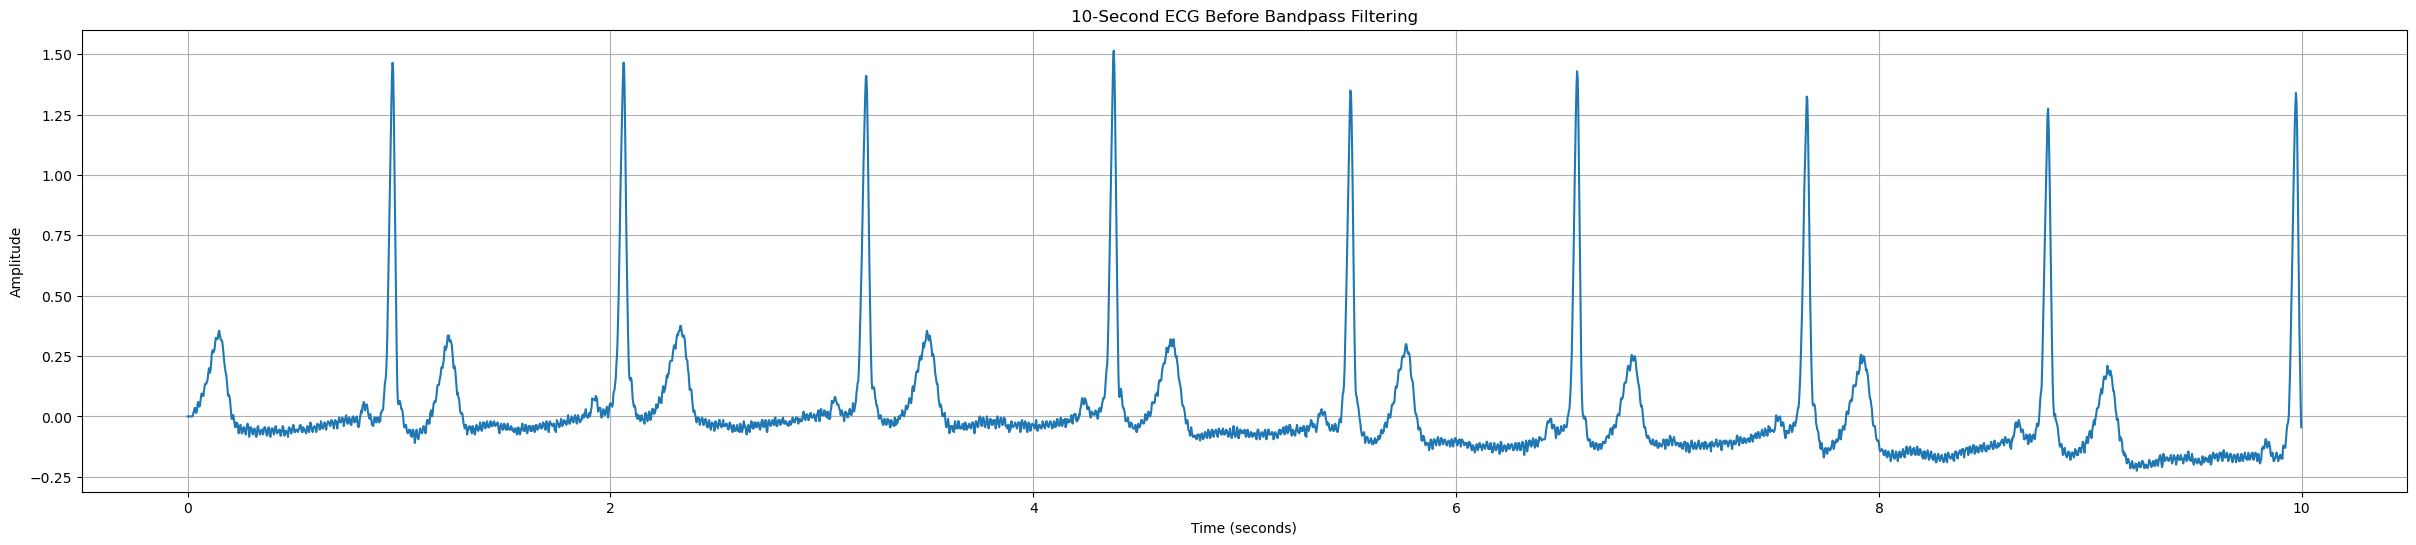

In [1]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt

# Path to the dataset
path = 'C:/Users/wen-xiang.lau/FYP/dataset/202'

# Read the ECG recording
record = wfdb.rdrecord(path)

# Access the ECG signal data
ecg_data = record.p_signal[:, 0] 

# Sampling frequency
fs = record.fs

# Generate time axis in seconds
time = np.arange(len(ecg_data)) / fs

# Define the segment duration in seconds
segment_duration = 10

# Calculate the number of samples in the segment
samples_per_segment = segment_duration * fs

# Selecting the segment
start_sample = 0
end_sample = int(start_sample + samples_per_segment)

# Slicing the data for the first 10 seconds
segment_ecg = ecg_data[start_sample:end_sample]
segment_time = time[start_sample:end_sample]

# Plotting the ECG signal segment
plt.figure(figsize=(30, 6))
plt.plot(segment_time, segment_ecg)
plt.title('10-Second ECG Before Bandpass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [2]:
# Define the bandpass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

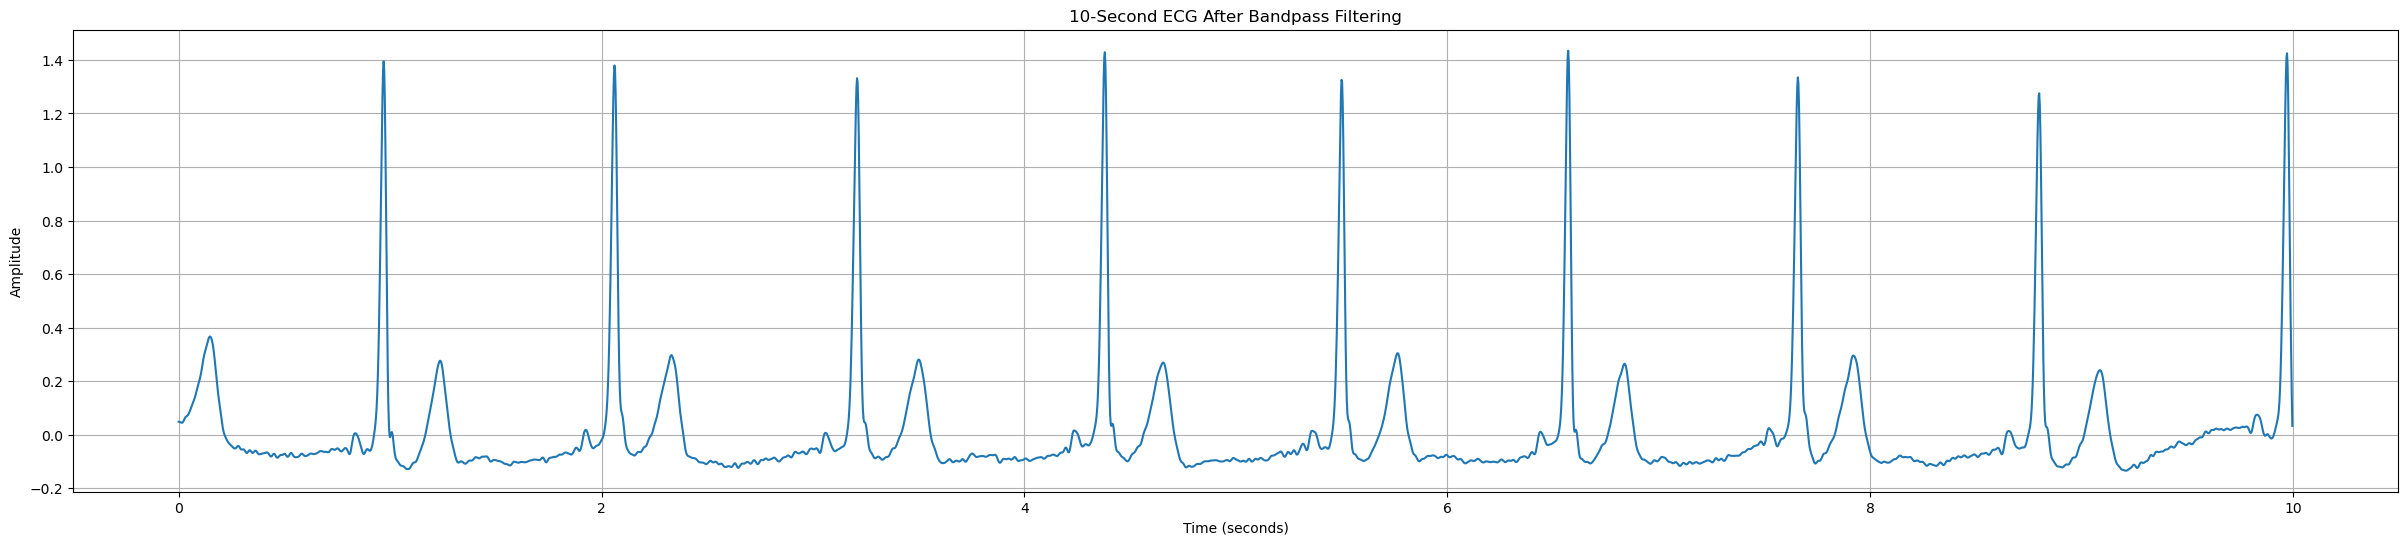

In [3]:
# Apply bandpass filter
clean_ecg = bandpass_filter(segment_ecg, 0.5, 40, fs, order=5)

# Plotting the ECG signal segment
plt.figure(figsize=(30, 6))
plt.plot(segment_time, clean_ecg)
plt.title('10-Second ECG After Bandpass Filtering')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [4]:
def add_noise_to_signal(clean_signal, noise_signal, target_snr_db):
    # Ensure the noise is the same length as the clean signal
    if len(noise_signal) > len(clean_signal):
        noise_signal = noise_signal[:len(clean_signal)]
    else:
        noise_signal = np.pad(noise_signal, (0, len(clean_signal) - len(noise_signal)), 'wrap')
    
    # Calculate signal power and convert to dB
    sig_power = np.mean(clean_signal ** 2)
    sig_power_db = 10 * np.log10(sig_power)
    
    # Calculate noise power and convert to dB
    noise_power = np.mean(noise_signal ** 2)
    noise_power_db = 10 * np.log10(noise_power)
    
    # Calculate the required noise adjustment to achieve target SNR
    required_noise_power_db = sig_power_db - target_snr_db
    required_noise_power = 10 ** (required_noise_power_db / 10)
    
    # Calculate the scaling factor for the noise
    scaling_factor = np.sqrt(required_noise_power / noise_power)
    
    # Scale the noise to the required power
    adjusted_noise = noise_signal * scaling_factor
    
    # Add the scaled noise to the clean signal
    noisy_signal = clean_signal + adjusted_noise
    
    return noisy_signal,adjusted_noise

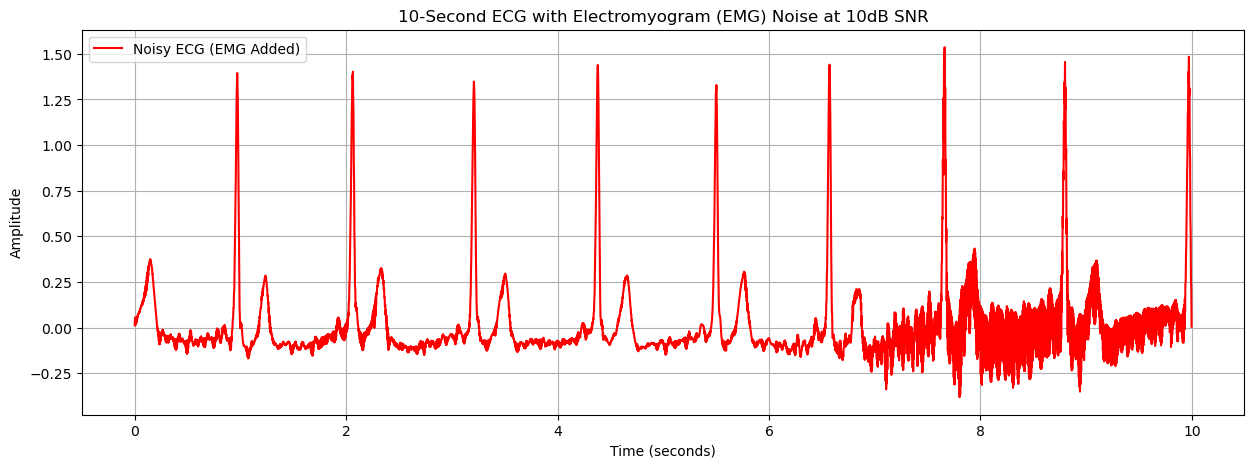

In [5]:
# Load EMG noise from MIT-BIH Noise Stress Test Database
emg_record = wfdb.rdrecord('C:/Users/wen-xiang.lau/FYP/noise/ma')
emg_noise = emg_record.p_signal.flatten() 

# Add EMG noise to the clean ECG at 10 dB SNR
noisy_ecg,adjusted_noise = add_noise_to_signal(clean_ecg, emg_noise, target_snr_db=10)

# Plot noisy ECG with EMG
plt.figure(figsize=(15, 5))
plt.plot(segment_time, noisy_ecg, label="Noisy ECG (EMG Added)", color='red')
plt.title('10-Second ECG with Electromyogram (EMG) Noise at 10dB SNR')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

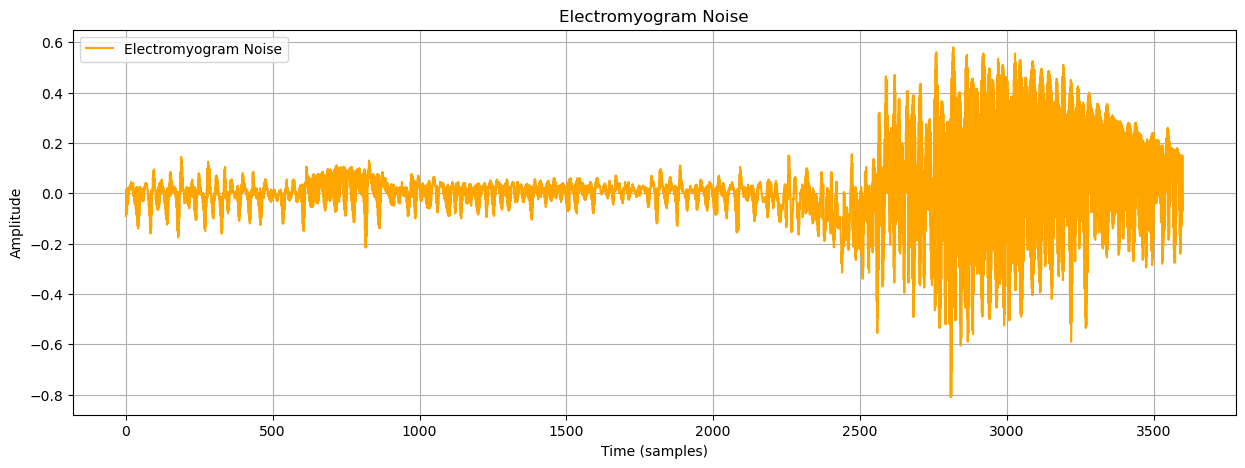

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(emg_noise[start_sample:end_sample], color='orange', label="Electromyogram Noise")
plt.title('Electromyogram Noise')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

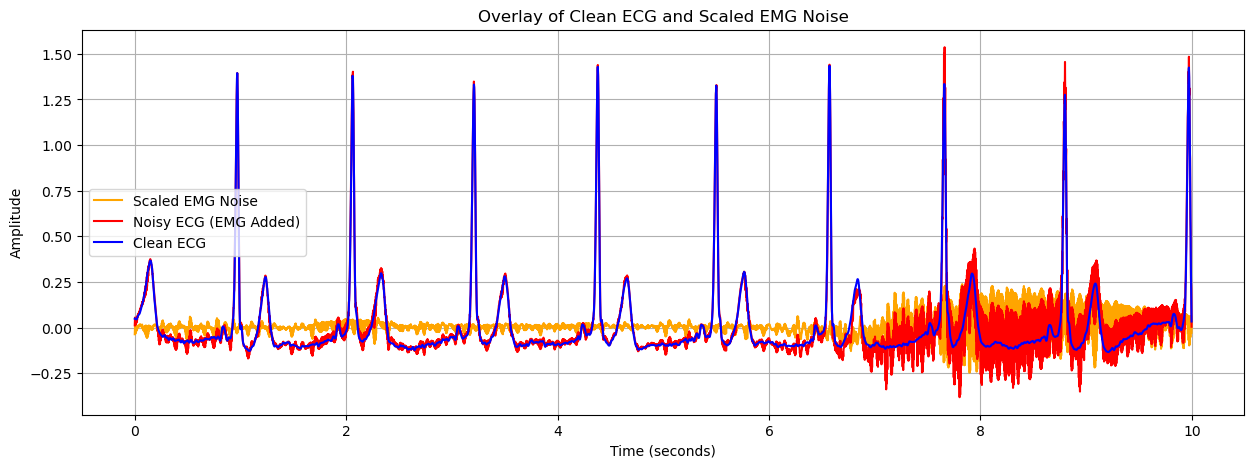

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(segment_time, adjusted_noise, label="Scaled EMG Noise", color="orange")
plt.plot(segment_time, noisy_ecg, label="Noisy ECG (EMG Added)", color='red')
plt.plot(segment_time, clean_ecg, label="Clean ECG", color="blue")

plt.title("Overlay of Clean ECG and Scaled EMG Noise")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# !pip install pywt

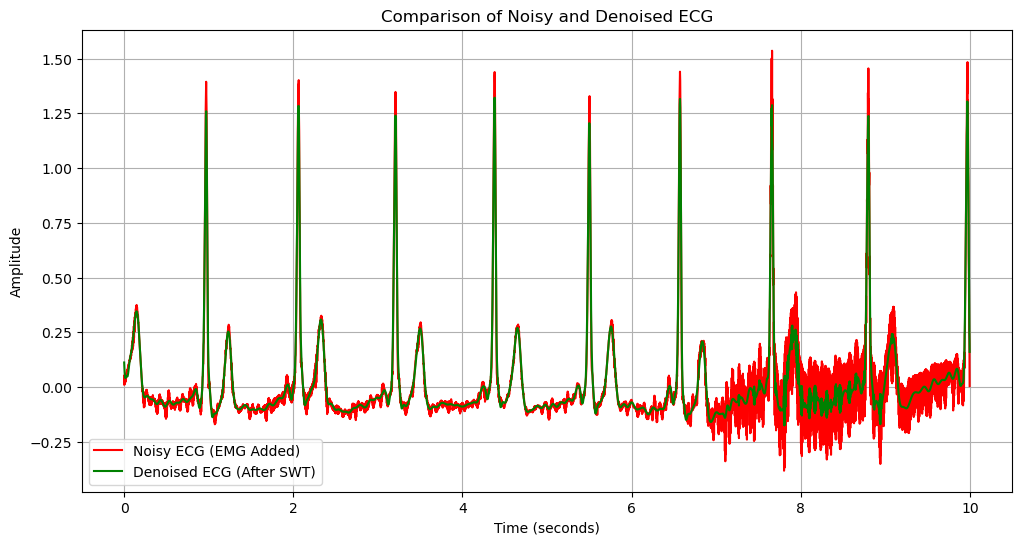

In [9]:
import pywt

threshold_cA = 0.01
threshold_cD = 0.2

# Perform SWT decomposition
coeffs = pywt.swt(noisy_ecg, wavelet='sym4', level=4)

# Apply soft thresholding to each coefficients
for i in range(len(coeffs)):
    cA, cD = coeffs[i]
    coeffs[i] = (pywt.threshold(cA, threshold_cA, mode='soft'), pywt.threshold(cD, threshold_cD, mode='soft'))

# Reconstruct the denoised signal using inverse SWT
denoised_ecg = pywt.iswt(coeffs, 'sym4')

# Plot final comparison
plt.figure(figsize=(12, 6))
plt.plot(segment_time, noisy_ecg, label="Noisy ECG (EMG Added)", color='red')
plt.plot(segment_time, denoised_ecg, label="Denoised ECG (After SWT)", color='green')
plt.title("Comparison of Noisy and Denoised ECG")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Compute Noise (Difference Between Clean and Denoised ECG)
noise = clean_ecg - denoised_ecg

# Compute SNR (Signal-to-Noise Ratio)
snr_value = 10 * np.log10(np.sum(clean_ecg ** 2) / np.sum(noise ** 2))


# Compute RMSE (Root Mean Square Error)
rmse_value = np.sqrt(np.mean((clean_ecg - denoised_ecg) ** 2))


# Compute PRD (Percentage Root Mean Difference)
prd_value = 100 * (np.linalg.norm(clean_ecg - denoised_ecg) / np.linalg.norm(clean_ecg))


print(f"SNR: {snr_value:.2f} dB")
print(f"RMSE: {rmse_value:.4f}")
print(f"PRD: {prd_value:.2f} %")


SNR: 17.38 dB
RMSE: 0.0298
PRD: 13.52 %


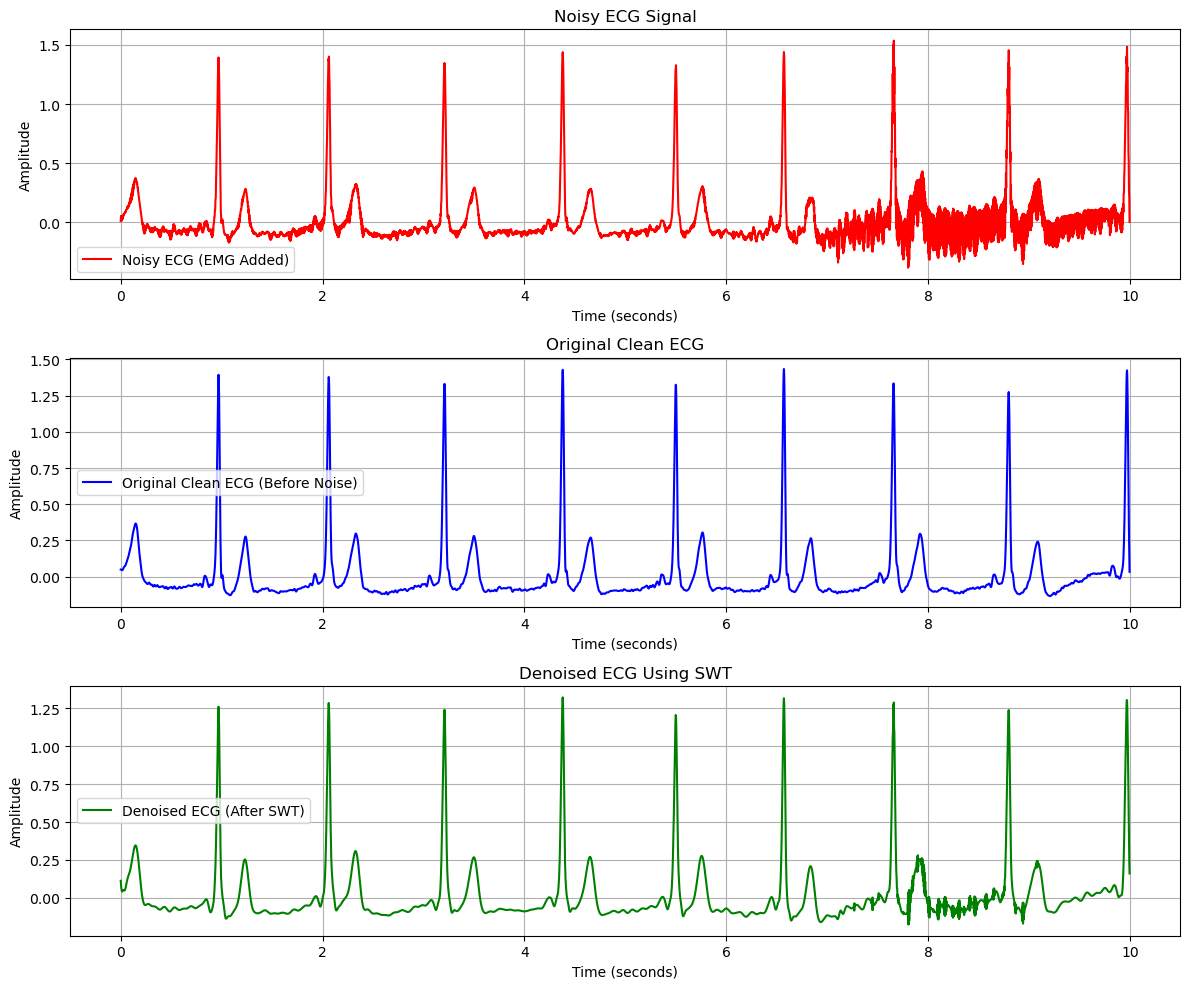

In [11]:
# Plot original, noisy, and SWT denoised ECG
plt.figure(figsize=(12, 10))

# Plot Noisy ECG
plt.subplot(3, 1, 1)
plt.plot(segment_time, noisy_ecg, label="Noisy ECG (EMG Added)", color='red')
plt.title("Noisy ECG Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot Original Clean ECG
plt.subplot(3, 1, 2)
plt.plot(segment_time, clean_ecg, label="Original Clean ECG (Before Noise)", color='blue')
plt.title("Original Clean ECG")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Plot Denoised ECG (SWT)
plt.subplot(3, 1, 3)
plt.plot(segment_time, denoised_ecg, label="Denoised ECG (After SWT)", color='green')
plt.title("Denoised ECG Using SWT")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()